#** ♻️ OBJECT DETECTION USING YOLOv8 ON CUSTOM WASTE BANK DATASET ♻️**

#####The goal of this project is to utilize the YOLOv8 model for object detection to accurately identify and classify waste materials sorted at a waste bank, leveraging a custom dataset to enhance sorting accuracy and operational efficiency.

### **Overview of the workflow**
1. Set up the notebook (google colab)
2. YOLOv8 Installation
3. Mount the Google Drive
4. Visualize the train images with their bounding boxes
5. Train the custom waste bank dataset
7. Run inference with the custom YOLOv8 Object Detection Trained Weight
8. Visualize the prediction by plotting validation images (test images) and their predicted bounding boxes

**Import the neccesary library**

In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 28.6 MB/s eta 0:00:00


In [2]:
import ultralytics

print(ultralytics.__version__)

8.2.45


In [3]:
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
import zipfile
from ultralytics import YOLO

## **Dataset**

the dataset gathered 30% new images + 70% images collected from websites and annotated using roboflow, then split to train(70%), valid(20%), and test(10%)

The dataset has 3 folders:

train - contains 4862 images.

valid - contains 249 images. Care has been taken to prevent any data leakage. Any image present in the train set is not a part of the val set.

test - contains 120 images.

Hence, effort has been made to create a good quality dataset because the quality of the predictions depends a lot on the quality of the dataset the model has been trained on.

Structure of the dataset:

number of classes in the dataset = 15

names: ['Background', 'Botol Kaca', 'Botol Plastik', 'Galon', 'Gelas Plastik', 'Kaleng', 'Kantong Plastik', 'Kantong Semen', 'Kardus', 'Kemasan Plastik', 'Kertas Bekas', 'Koran', 'Pecahan Kaca', 'Toples Kaca', 'Tutup Galon']

dataset

|__ train

----|______ images

----|______ labels

|__ val

----|______ images

----|______ labels

|__ test

----|______ images

----|______ labels


The Dataset Loaded From github

In [4]:
!git clone https://github.com/wastebank-project/machine_learning.git

Cloning into 'machine_learning'...
remote: Enumerating objects: 10415, done.
remote: Counting objects: 100% (371/371), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 10415 (delta 8), reused 371 (delta 8), pack-reused 10044
Receiving objects: 100% (10415/10415), 210.75 MiB | 70.34 MiB/s, done.
Resolving deltas: 100% (12/12), done.
Updating files: 100% (18878/18878), done.


#  Visualize the train images with their bounding boxes

For object detection, the bounding box coordinates for the data can be in many different formats

1. x_min, y_min, x_max, y_max (general)
2. x1, y1, x2, y2
3. coco format: x, y, w, h
4. yolo format: x_center_normalized, y_center_normalized, bbox_w_normalized, bbox_h_normalized

To convert the bounding boxes from the yolo format to x_min, y_min, x_max, y_max, must perform the following operation.

In [4]:
# Function to convert bounding boxes in YOLO format to x_min, y_min, x_max, y_max.

def yolo2bbox(bboxes):

    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
# Function to plot the bounding boxes.

def plot_box(image, bboxes, labels):

    # Need the image height and width to denormalize the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)

        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        # calculate the thickness of the bounding box lines based on the image width
        # to make sure the boxes are visible in the plot.
        thickness = max(2, int(w/275))

        # draw a rectangle on the image
        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            #  color (0, 0, 255) -> red
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

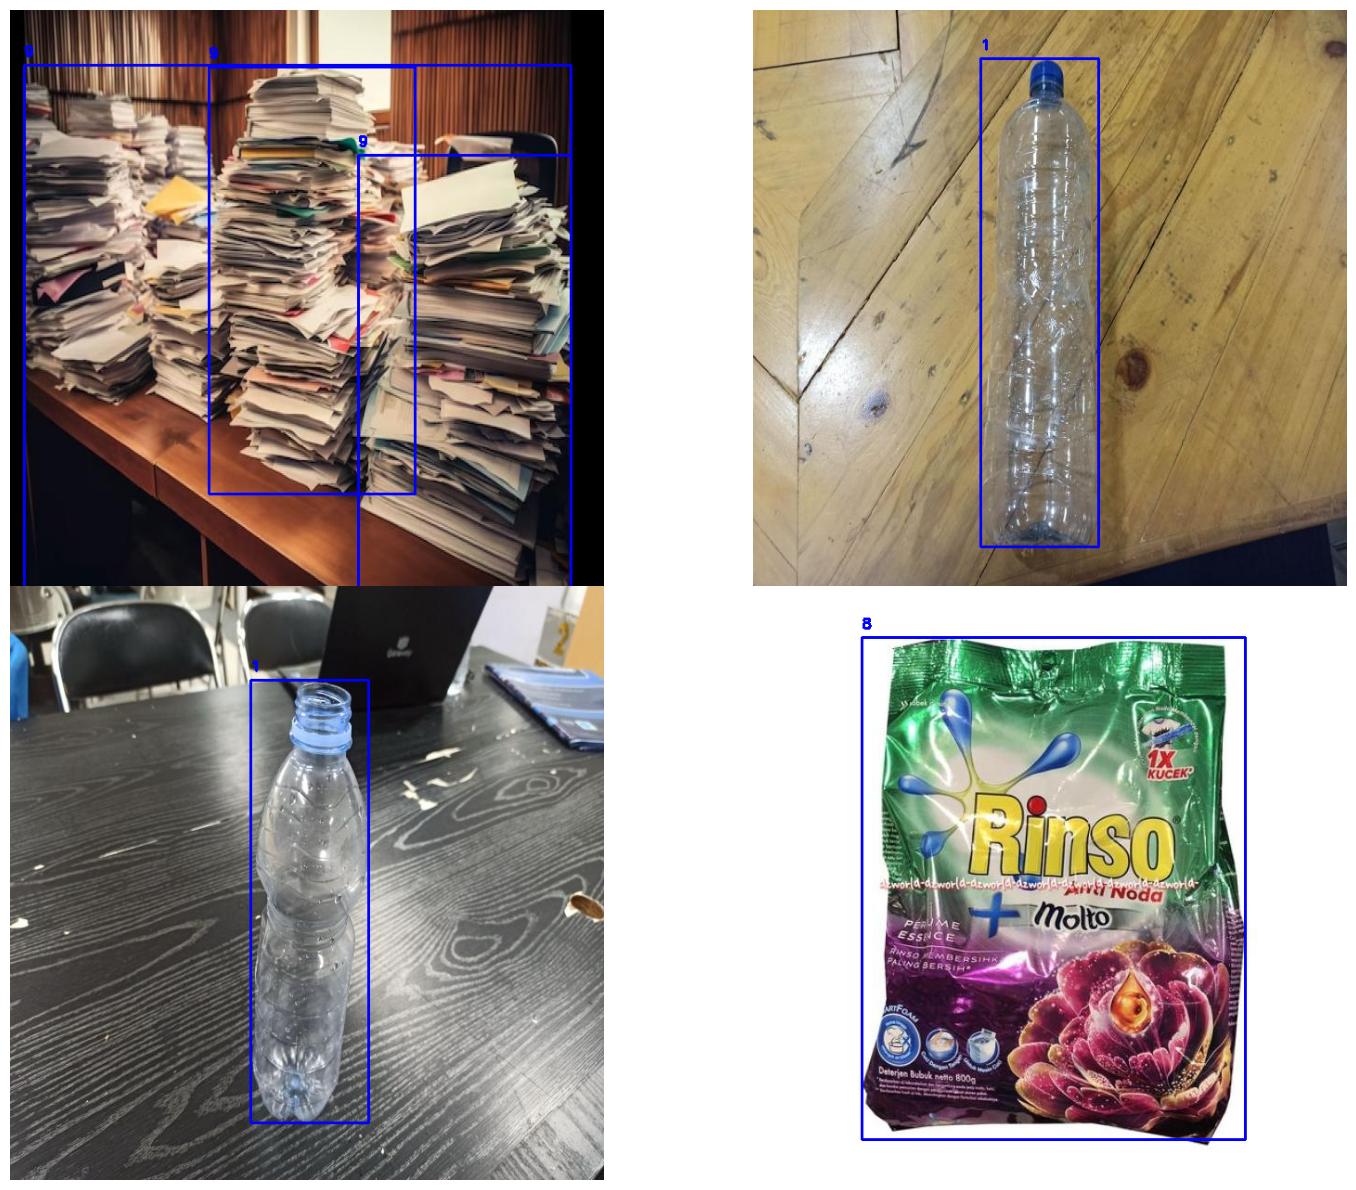

In [5]:
def plot_box(image, bboxes, labels):
    """
    Draws bounding boxes and labels on the image.
    """
    for (x_c, y_c, w, h), label in zip(bboxes, labels):
        # Convert from center coordinates to corner coordinates
        x1 = int((x_c - w / 2) * image.shape[1])
        y1 = int((y_c - h / 2) * image.shape[0])
        x2 = int((x_c + w / 2) * image.shape[1])
        y2 = int((y_c + h / 2) * image.shape[0])

        # Draw the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Place the label
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    return image

def plot(image_paths, label_paths, num_samples):
    all_images = glob.glob(os.path.join(image_paths, '*.jpg')) + glob.glob(os.path.join(image_paths, '*.JPG'))
    all_images.sort()

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        idx = random.randint(0, len(all_images) - 1)
        image_path = all_images[idx]
        label_path = os.path.join(label_paths, os.path.basename(image_path).replace('.jpg', '.txt').replace('.JPG', '.txt'))

        image = cv2.imread(image_path)
        bboxes = []
        labels = []

        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    label = parts[0]
                    x_c, y_c, w, h = map(float, parts[1:])
                    bboxes.append([x_c, y_c, w, h])
                    labels.append(label)

        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i + 1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')

    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

# visualize a few training images
plot(
    image_paths='/notebooks/dataset.yolo/train/images',
    label_paths='/notebooks/dataset.yolo/train/labels',
    num_samples=4
)

# Train the custom waste bank dataset

In [15]:
# Disable wandb by setting the environment variable
os.environ['WANDB_MODE'] = 'disabled'

# Load a pre-trained YOLOv8 small model
model = YOLO('yolov8s.pt')

# Train the model
model.train(
    data='/notebooks/dataset.yolo/data.yaml',
    optimizer= 'Adam',
    epochs=100,
    batch=16,
    lr0=0.01,
    lrf=0.01,
    weight_decay=1e-4,
    workers=8,
    imgsz=640,
    name='yolov8s_e100_lr0.01'
)

Ultralytics YOLOv8.2.45 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/notebooks/dataset.yolo/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_e100_lr0.01, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

train: Scanning /notebooks/dataset.yolo/train/labels.cache... 1952 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1952/1952 [00:00<?, ?it/s]
val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_e100_lr0.01/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolov8s_e100_lr0.01
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      4.33G      1.462      3.568      1.799         53        640: 100%|██████████| 122/122 [01:33<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]

                   all        564        877      0.072      0.108   0.000539   0.000157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      4.23G      1.563      3.234      1.884         37        640: 100%|██████████| 122/122 [00:11<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  6.20it/s]


                   all        564        877     0.0158      0.183     0.0128    0.00488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      4.24G      1.506      3.124      1.847         51        640: 100%|██████████| 122/122 [00:11<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.88it/s]


                   all        564        877     0.0194      0.148     0.0265     0.0116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      4.22G      1.425      2.983      1.767         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.88it/s]


                   all        564        877      0.208      0.215     0.0489     0.0225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      4.23G      1.364      2.891       1.72         64        640: 100%|██████████| 122/122 [00:11<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.69it/s]


                   all        564        877      0.261      0.239      0.103     0.0595

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      4.22G      1.329      2.819      1.695         60        640: 100%|██████████| 122/122 [00:11<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


                   all        564        877      0.334      0.287      0.161      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      4.23G      1.303      2.779      1.657         61        640: 100%|██████████| 122/122 [00:11<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.00it/s]


                   all        564        877      0.214      0.274      0.121     0.0675

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      4.23G      1.237      2.705      1.613         56        640: 100%|██████████| 122/122 [00:11<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.06it/s]


                   all        564        877       0.37      0.268      0.158     0.0956

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      4.22G      1.223      2.628      1.597         46        640: 100%|██████████| 122/122 [00:11<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.94it/s]


                   all        564        877      0.169      0.299      0.169      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      4.22G      1.206      2.613      1.582         58        640: 100%|██████████| 122/122 [00:11<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.36it/s]

                   all        564        877      0.337      0.307      0.168      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      4.23G      1.178      2.588      1.553         50        640: 100%|██████████| 122/122 [00:11<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.80it/s]


                   all        564        877      0.181      0.296      0.187      0.129

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      4.24G      1.147      2.494      1.536         63        640: 100%|██████████| 122/122 [00:11<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.01it/s]


                   all        564        877      0.295      0.328      0.229      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      4.22G      1.122       2.46      1.515         80        640: 100%|██████████| 122/122 [00:11<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.88it/s]


                   all        564        877      0.194      0.278      0.206      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      4.23G      1.132      2.434      1.519         58        640: 100%|██████████| 122/122 [00:11<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.72it/s]

                   all        564        877      0.279      0.381       0.28        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      4.23G       1.13      2.381      1.512         42        640: 100%|██████████| 122/122 [00:11<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.98it/s]


                   all        564        877      0.267       0.37      0.283      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      4.22G      1.082      2.388       1.49         56        640: 100%|██████████| 122/122 [00:10<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.19it/s]


                   all        564        877      0.327       0.39      0.271      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      4.22G      1.087      2.338      1.491         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.91it/s]


                   all        564        877      0.243      0.341      0.281      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      4.23G      1.086      2.297      1.469         49        640: 100%|██████████| 122/122 [00:11<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.97it/s]


                   all        564        877      0.333      0.406      0.325      0.238

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      4.23G      1.043      2.242      1.451         48        640: 100%|██████████| 122/122 [00:11<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.01it/s]


                   all        564        877      0.303       0.42      0.331      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      4.23G      1.055      2.234      1.451         67        640: 100%|██████████| 122/122 [00:11<00:00, 10.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.94it/s]


                   all        564        877      0.335      0.403      0.333      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      4.23G       1.06      2.222      1.464         38        640: 100%|██████████| 122/122 [00:11<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.10it/s]


                   all        564        877       0.34       0.42      0.338      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      4.22G      1.033      2.194      1.436         56        640: 100%|██████████| 122/122 [00:11<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.05it/s]


                   all        564        877      0.466      0.349      0.372       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      4.23G      1.044      2.194      1.452         45        640: 100%|██████████| 122/122 [00:11<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.13it/s]


                   all        564        877      0.427       0.42      0.402      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      4.23G      1.025      2.145      1.429         59        640: 100%|██████████| 122/122 [00:11<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.95it/s]


                   all        564        877       0.46      0.417      0.423      0.322

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      4.22G       1.01      2.114      1.416         59        640: 100%|██████████| 122/122 [00:11<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.95it/s]


                   all        564        877      0.344      0.423      0.379      0.275

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      4.23G      1.023       2.06      1.416         66        640: 100%|██████████| 122/122 [00:11<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.15it/s]


                   all        564        877      0.438      0.441      0.418      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      4.23G      1.012      2.059      1.421         59        640: 100%|██████████| 122/122 [00:11<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


                   all        564        877      0.447      0.387      0.378       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      4.22G       0.99      2.024      1.397         51        640: 100%|██████████| 122/122 [00:11<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


                   all        564        877      0.462      0.425      0.435      0.317

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      4.22G      0.989      2.007      1.401         54        640: 100%|██████████| 122/122 [00:11<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.21it/s]


                   all        564        877      0.464      0.522      0.462      0.344

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      4.22G     0.9727      2.008      1.396         52        640: 100%|██████████| 122/122 [00:11<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


                   all        564        877      0.467      0.449      0.469      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      4.22G     0.9744      1.995      1.399         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.24it/s]


                   all        564        877      0.552      0.416      0.463      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.23G     0.9642      1.897       1.38         82        640: 100%|██████████| 122/122 [00:11<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.02it/s]


                   all        564        877      0.457      0.441      0.436      0.312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.22G     0.9501      1.919      1.372         63        640: 100%|██████████| 122/122 [00:11<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:02<00:00,  8.97it/s]

                   all        564        877      0.538      0.454      0.499      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.23G     0.9385      1.862       1.37         51        640: 100%|██████████| 122/122 [00:11<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.07it/s]


                   all        564        877      0.565      0.501      0.528      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      4.24G     0.9511      1.857      1.367         48        640: 100%|██████████| 122/122 [00:11<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.18it/s]


                   all        564        877      0.511      0.473      0.499      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      4.23G     0.9402      1.821      1.362         82        640: 100%|██████████| 122/122 [00:11<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.07it/s]


                   all        564        877      0.469      0.519      0.515      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.22G     0.9196      1.805      1.357         60        640: 100%|██████████| 122/122 [00:11<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


                   all        564        877      0.517      0.526       0.54      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.24G     0.9201      1.754      1.352         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.10it/s]


                   all        564        877      0.566      0.552      0.573      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      4.22G     0.9038      1.772      1.343         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.10it/s]


                   all        564        877       0.55      0.555      0.576      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.23G     0.9082      1.748      1.339         48        640: 100%|██████████| 122/122 [00:11<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.10it/s]


                   all        564        877      0.562      0.535      0.547      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.22G      0.909      1.759      1.359         66        640: 100%|██████████| 122/122 [00:11<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.24it/s]


                   all        564        877      0.492      0.478      0.498      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.23G     0.9059      1.736      1.341         58        640: 100%|██████████| 122/122 [00:11<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


                   all        564        877      0.547       0.51      0.553      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.22G     0.8943      1.695      1.332         56        640: 100%|██████████| 122/122 [00:11<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.27it/s]


                   all        564        877      0.571      0.498      0.539      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.24G       0.89      1.685      1.334         61        640: 100%|██████████| 122/122 [00:11<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.17it/s]


                   all        564        877      0.533      0.557      0.581      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.22G     0.8851      1.663      1.318         70        640: 100%|██████████| 122/122 [00:11<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


                   all        564        877      0.599      0.549      0.583      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.23G     0.8565      1.601      1.299         40        640: 100%|██████████| 122/122 [00:11<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


                   all        564        877      0.561      0.584      0.586      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.24G     0.8708      1.618      1.314         44        640: 100%|██████████| 122/122 [00:11<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.05it/s]


                   all        564        877       0.58      0.569      0.597      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.22G     0.8763       1.61      1.329         58        640: 100%|██████████| 122/122 [00:11<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


                   all        564        877      0.531      0.575      0.588      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.23G     0.8709      1.605      1.317         41        640: 100%|██████████| 122/122 [00:11<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.19it/s]


                   all        564        877      0.646      0.561       0.64      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.23G     0.8468      1.577      1.296         50        640: 100%|██████████| 122/122 [00:11<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.25it/s]


                   all        564        877      0.613      0.567      0.614      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.23G     0.8538       1.56      1.301         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.35it/s]


                   all        564        877      0.639      0.597      0.641      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.22G     0.8508      1.517      1.297         60        640: 100%|██████████| 122/122 [00:11<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


                   all        564        877      0.612      0.584      0.629      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.22G     0.8515      1.535      1.306         46        640: 100%|██████████| 122/122 [00:11<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.25it/s]


                   all        564        877      0.649      0.577      0.644      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.22G      0.838      1.491      1.293         44        640: 100%|██████████| 122/122 [00:11<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


                   all        564        877      0.674      0.561      0.642      0.512

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.23G     0.8311      1.506      1.292         62        640: 100%|██████████| 122/122 [00:11<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


                   all        564        877      0.636      0.572      0.649      0.526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      4.24G     0.8594       1.49      1.303         60        640: 100%|██████████| 122/122 [00:11<00:00, 10.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.17it/s]


                   all        564        877      0.695      0.538      0.632      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.22G     0.8193      1.441       1.27         39        640: 100%|██████████| 122/122 [00:11<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.23it/s]


                   all        564        877      0.635      0.566      0.649      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.23G     0.8406      1.469      1.283         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]


                   all        564        877      0.652      0.617       0.66      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.23G     0.8122      1.442      1.272         75        640: 100%|██████████| 122/122 [00:11<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


                   all        564        877       0.69      0.568       0.65      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.22G     0.8035      1.384      1.263         59        640: 100%|██████████| 122/122 [00:11<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.23it/s]


                   all        564        877      0.652      0.643      0.683      0.554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      4.22G     0.8113      1.401      1.271         57        640: 100%|██████████| 122/122 [00:11<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


                   all        564        877      0.646      0.613      0.674      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      4.23G     0.8057      1.371      1.265         50        640: 100%|██████████| 122/122 [00:11<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.11it/s]


                   all        564        877      0.651      0.628      0.678      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      4.23G     0.7887      1.351      1.248         66        640: 100%|██████████| 122/122 [00:11<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.33it/s]


                   all        564        877      0.629      0.651      0.699       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      4.22G     0.7941      1.342      1.261         56        640: 100%|██████████| 122/122 [00:11<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.18it/s]


                   all        564        877      0.701      0.577      0.679      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      4.23G     0.7975      1.373      1.256         58        640: 100%|██████████| 122/122 [00:11<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.26it/s]


                   all        564        877      0.701      0.605      0.692      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      4.22G      0.769      1.278      1.243         62        640: 100%|██████████| 122/122 [00:11<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


                   all        564        877      0.658      0.644       0.69      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      4.22G     0.7777      1.304      1.247         63        640: 100%|██████████| 122/122 [00:11<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.36it/s]


                   all        564        877      0.661      0.615      0.682      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      4.22G     0.7814      1.303      1.248         58        640: 100%|██████████| 122/122 [00:11<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.15it/s]


                   all        564        877      0.702      0.607      0.691      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      4.23G     0.7771      1.285      1.242         54        640: 100%|██████████| 122/122 [00:11<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


                   all        564        877      0.694      0.611      0.688      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      4.22G     0.7583      1.272      1.237         62        640: 100%|██████████| 122/122 [00:11<00:00, 10.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.01it/s]


                   all        564        877      0.714       0.64      0.716      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      4.22G     0.7483      1.213      1.227         61        640: 100%|██████████| 122/122 [00:11<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.26it/s]


                   all        564        877      0.696      0.648      0.709       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      4.24G     0.7595      1.267      1.238         53        640: 100%|██████████| 122/122 [00:11<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]


                   all        564        877      0.724      0.636      0.721      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      4.23G     0.7473      1.228      1.236         83        640: 100%|██████████| 122/122 [00:11<00:00, 10.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.26it/s]


                   all        564        877      0.703      0.622      0.707      0.591

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      4.23G     0.7526      1.213      1.231         59        640: 100%|██████████| 122/122 [00:11<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


                   all        564        877      0.708      0.677       0.73      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      4.22G     0.7382      1.185      1.218         50        640: 100%|██████████| 122/122 [00:11<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.30it/s]


                   all        564        877      0.676      0.637      0.683      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      4.23G     0.7524      1.178       1.23         44        640: 100%|██████████| 122/122 [00:11<00:00, 10.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.17it/s]


                   all        564        877      0.699      0.649      0.722      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      4.24G     0.7502      1.193      1.226         67        640: 100%|██████████| 122/122 [00:11<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


                   all        564        877      0.718      0.657      0.731       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      4.24G     0.7219      1.132      1.202         52        640: 100%|██████████| 122/122 [00:11<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.37it/s]


                   all        564        877      0.672      0.681      0.723      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      4.23G     0.7122       1.11      1.199         56        640: 100%|██████████| 122/122 [00:11<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.17it/s]


                   all        564        877      0.677      0.687      0.722      0.605

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.23G     0.7122       1.08      1.202         50        640: 100%|██████████| 122/122 [00:11<00:00, 10.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.62it/s]

                   all        564        877      0.757      0.642      0.741      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      4.23G     0.7164      1.126      1.211         52        640: 100%|██████████| 122/122 [00:11<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


                   all        564        877       0.71      0.661      0.722      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      4.22G     0.7168      1.084      1.208         56        640: 100%|██████████| 122/122 [00:11<00:00, 10.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]


                   all        564        877      0.737      0.662      0.741      0.619

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      4.23G     0.7158      1.064      1.207         54        640: 100%|██████████| 122/122 [00:11<00:00, 10.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


                   all        564        877      0.728      0.679      0.748      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      4.24G     0.7131      1.058      1.198         43        640: 100%|██████████| 122/122 [00:11<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.24it/s]


                   all        564        877      0.715      0.673      0.733      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      4.22G     0.6915      1.034      1.187         44        640: 100%|██████████| 122/122 [00:11<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]

                   all        564        877      0.751      0.647      0.743      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      4.23G     0.6814      1.025      1.183         45        640: 100%|██████████| 122/122 [00:11<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.28it/s]


                   all        564        877      0.743      0.674      0.741      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      4.23G     0.6866      1.021      1.178         51        640: 100%|██████████| 122/122 [00:11<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.34it/s]

                   all        564        877      0.738      0.676      0.755      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      4.22G     0.6957      1.012      1.194         57        640: 100%|██████████| 122/122 [00:11<00:00, 10.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


                   all        564        877      0.744      0.693      0.757      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      4.24G     0.6675     0.9899       1.17         48        640: 100%|██████████| 122/122 [00:10<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.18it/s]

                   all        564        877      0.724      0.686      0.758      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      4.24G      0.666     0.9564      1.176         61        640: 100%|██████████| 122/122 [00:11<00:00, 10.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.16it/s]

                   all        564        877      0.687      0.726       0.76      0.641


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      4.23G     0.5988     0.8801      1.184         20        640: 100%|██████████| 122/122 [00:11<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.30it/s]

                   all        564        877       0.76      0.681      0.757      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      4.23G      0.587     0.8263      1.166         34        640: 100%|██████████| 122/122 [00:11<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.71it/s]

                   all        564        877      0.739        0.7      0.767      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.22G     0.5679     0.7838      1.149         31        640: 100%|██████████| 122/122 [00:11<00:00, 11.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.31it/s]

                   all        564        877      0.741      0.724      0.778      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.24G     0.5504     0.7529      1.133         32        640: 100%|██████████| 122/122 [00:11<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.29it/s]

                   all        564        877      0.753        0.7      0.775      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.23G     0.5435     0.7222      1.121         30        640: 100%|██████████| 122/122 [00:10<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.39it/s]

                   all        564        877       0.72       0.72      0.776      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.22G     0.5371     0.6982      1.118         25        640: 100%|██████████| 122/122 [00:11<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


                   all        564        877      0.748      0.729      0.784      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.22G     0.5274     0.6821      1.113         22        640: 100%|██████████| 122/122 [00:11<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.37it/s]


                   all        564        877      0.756      0.682      0.766      0.652

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      4.22G     0.5194     0.6664      1.097         30        640: 100%|██████████| 122/122 [00:11<00:00, 10.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.32it/s]

                   all        564        877      0.774       0.69      0.771      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.22G     0.5249     0.6706      1.101         35        640: 100%|██████████| 122/122 [00:11<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.22it/s]


                   all        564        877      0.774      0.696      0.778      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.22G     0.5102     0.6416      1.097         22        640: 100%|██████████| 122/122 [00:11<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:01<00:00,  9.41it/s]

                   all        564        877      0.756      0.712      0.777      0.666



100 epochs completed in 0.419 hours.
Optimizer stripped from runs/detect/yolov8s_e100_lr0.01/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_e100_lr0.01/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_e100_lr0.01/weights/best.pt...
Ultralytics YOLOv8.2.45 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]


                   all        564        877      0.773      0.698      0.778      0.668
             BotolKaca         40         40      0.705      0.825      0.838      0.735
          BotolPlastik         45         47      0.771      0.894      0.901       0.85
                 Galon         44         62      0.937      0.717      0.838      0.696
          GelasPlastik         40         87      0.907      0.561      0.737      0.594
                Kaleng         40         62      0.821      0.823       0.89      0.858
        KantongPlastik         41         46      0.828       0.87      0.929       0.84
          KantongSemen         40         56      0.838      0.554      0.718      0.602
                Kardus         40         79      0.649      0.609      0.636      0.499
        KemasanPlastik         40         69      0.757       0.58      0.695      0.545
           KertasBekas         40         66      0.758      0.523      0.701      0.619
                 Kora

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f481bf12ad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.0

In [34]:
from ultralytics import YOLO
import os

# Load the model
model_path = '/notebooks/runs/detect/yolov8s_e50_lr0.01/weights/best.pt'
model = YOLO(model_path)

# Validate the model 
results = model.val(data='/notebooks/dataset.yolo/data.yaml', imgsz=640)

# Extract metrics and save to a text file
metrics = results.results_dict
save_path = os.path.join(os.path.dirname(model_path), 'val_100_0,01.txt')  # Save next to the model

with open(save_path, 'w') as f:
    for metric_name, metric_value in metrics.items():
        f.write(f"{metric_name}: {metric_value}\n")

print(f"Validation results saved to: {save_path}")

Ultralytics YOLOv8.2.45 🚀 Python-3.11.7 torch-2.1.1+cu121 CUDA:0 (NVIDIA RTX A6000, 48677MiB)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /notebooks/dataset.yolo/valid/labels.cache... 564 images, 0 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 36/36 [00:04<00:00,  7.61it/s]


                   all        564        877      0.732      0.627      0.713      0.605
             BotolKaca         40         40      0.646       0.75      0.755      0.581
          BotolPlastik         45         47      0.779      0.748      0.859      0.785
                 Galon         44         62      0.788      0.645      0.788      0.667
          GelasPlastik         40         87      0.846      0.504       0.68      0.553
                Kaleng         40         62      0.891      0.823      0.904      0.857
        KantongPlastik         41         46      0.626      0.761      0.781      0.689
          KantongSemen         40         56       0.76      0.446      0.607      0.529
                Kardus         40         79      0.621      0.608      0.636      0.486
        KemasanPlastik         40         69      0.725      0.507      0.591      0.504
           KertasBekas         40         66      0.673      0.467      0.534      0.451
                 Kora

# METRICS EVALUATION

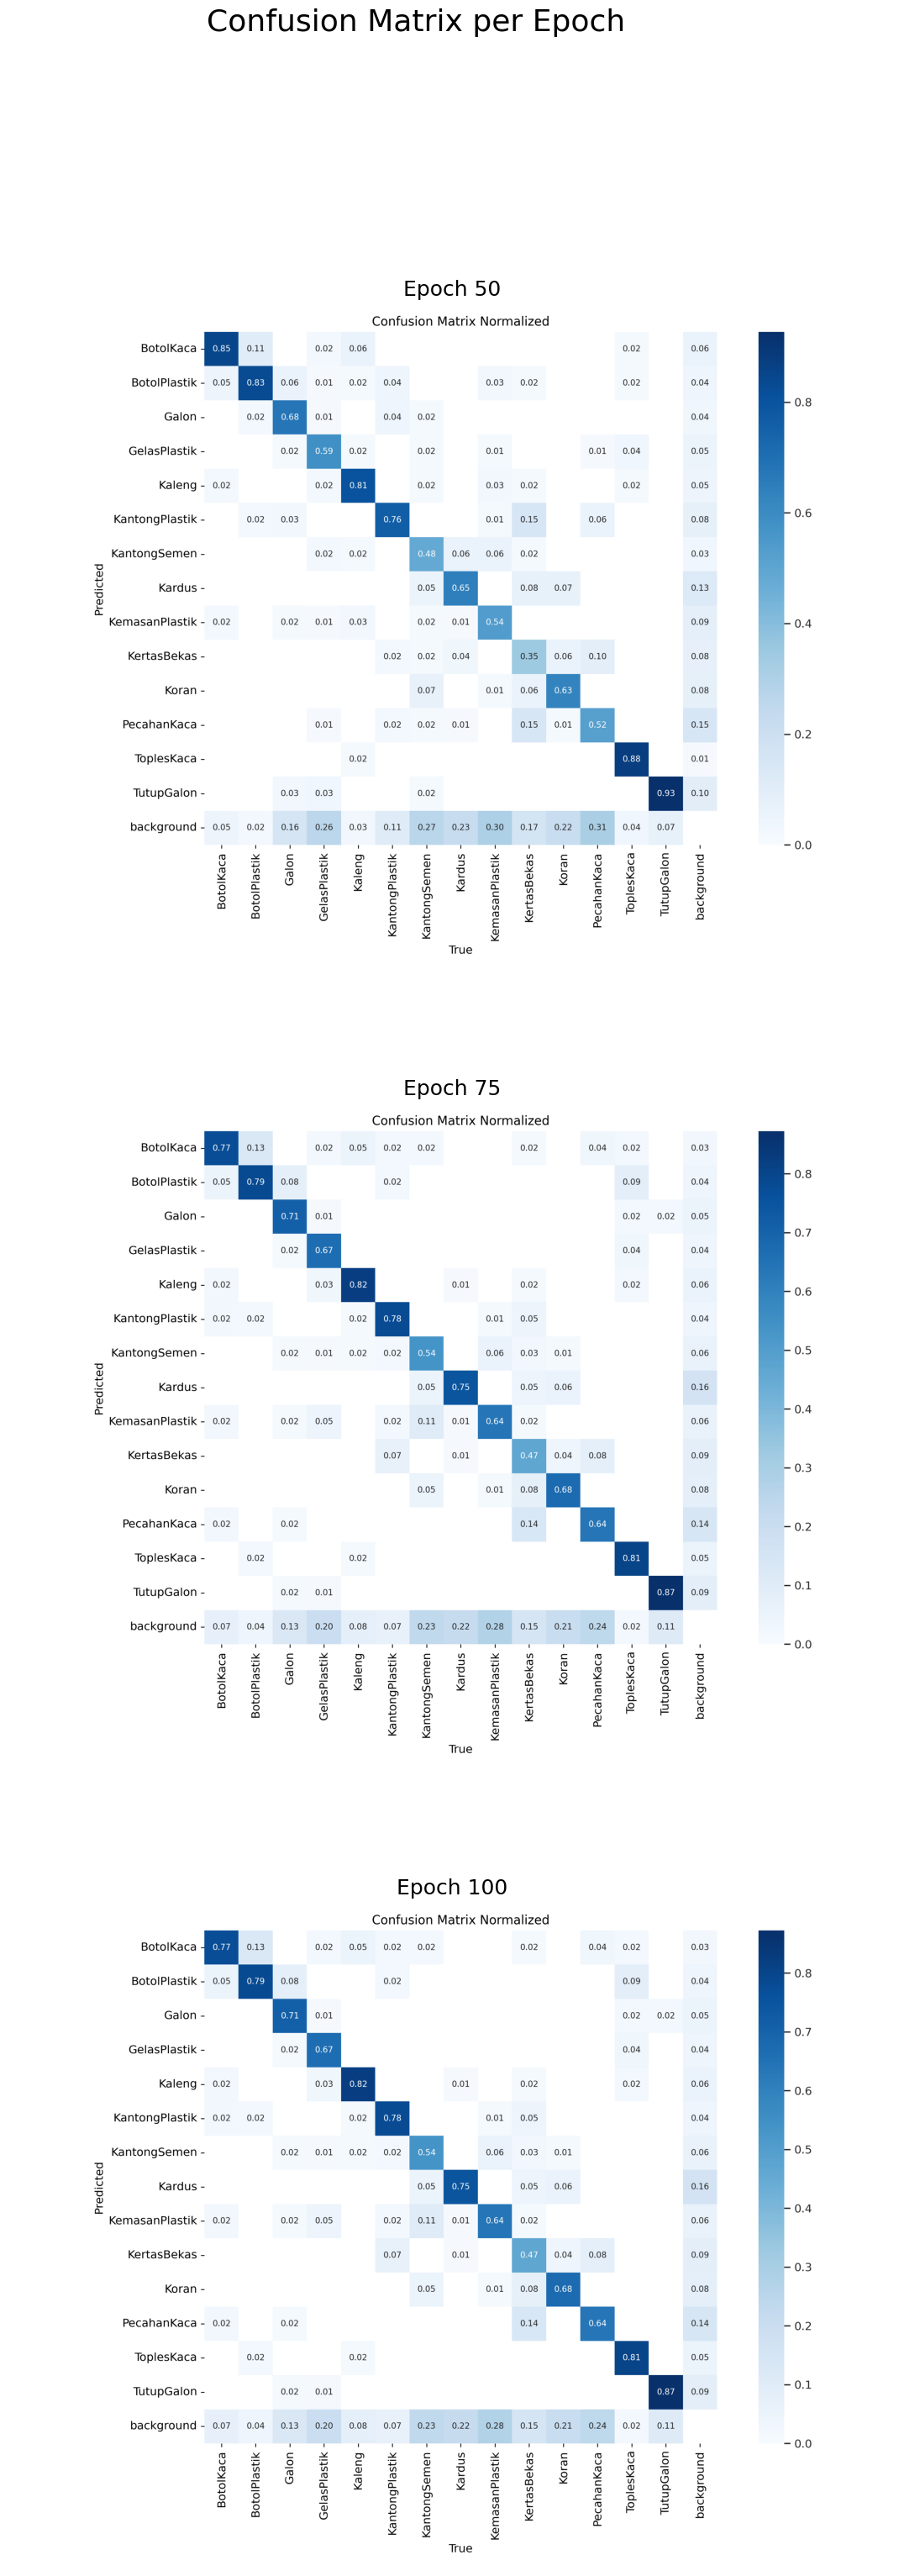

In [30]:
#show confusion matrix per epoch
images = [cv2.imread(f) for f in ["/notebooks/runs/detect/yolov8s_e50_lr0.01/confusion_matrix_normalized.png", 
               "/notebooks/runs/detect/yolov8s_e75_lr0.01/confusion_matrix_normalized.png", 
               "/notebooks/runs/detect/yolov8s_e75_lr0.01/confusion_matrix_normalized.png"]]

titles = ["Epoch 50", "Epoch 75", "Epoch 100"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(35, 35))

# Tampilkan setiap gambar pada axes yang sesuai
for i, img in enumerate(images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(titles[i], fontsize=18)

# Tambahkan judul utama
plt.suptitle("Confusion Matrix per Epoch", fontsize=26)

plt.show()

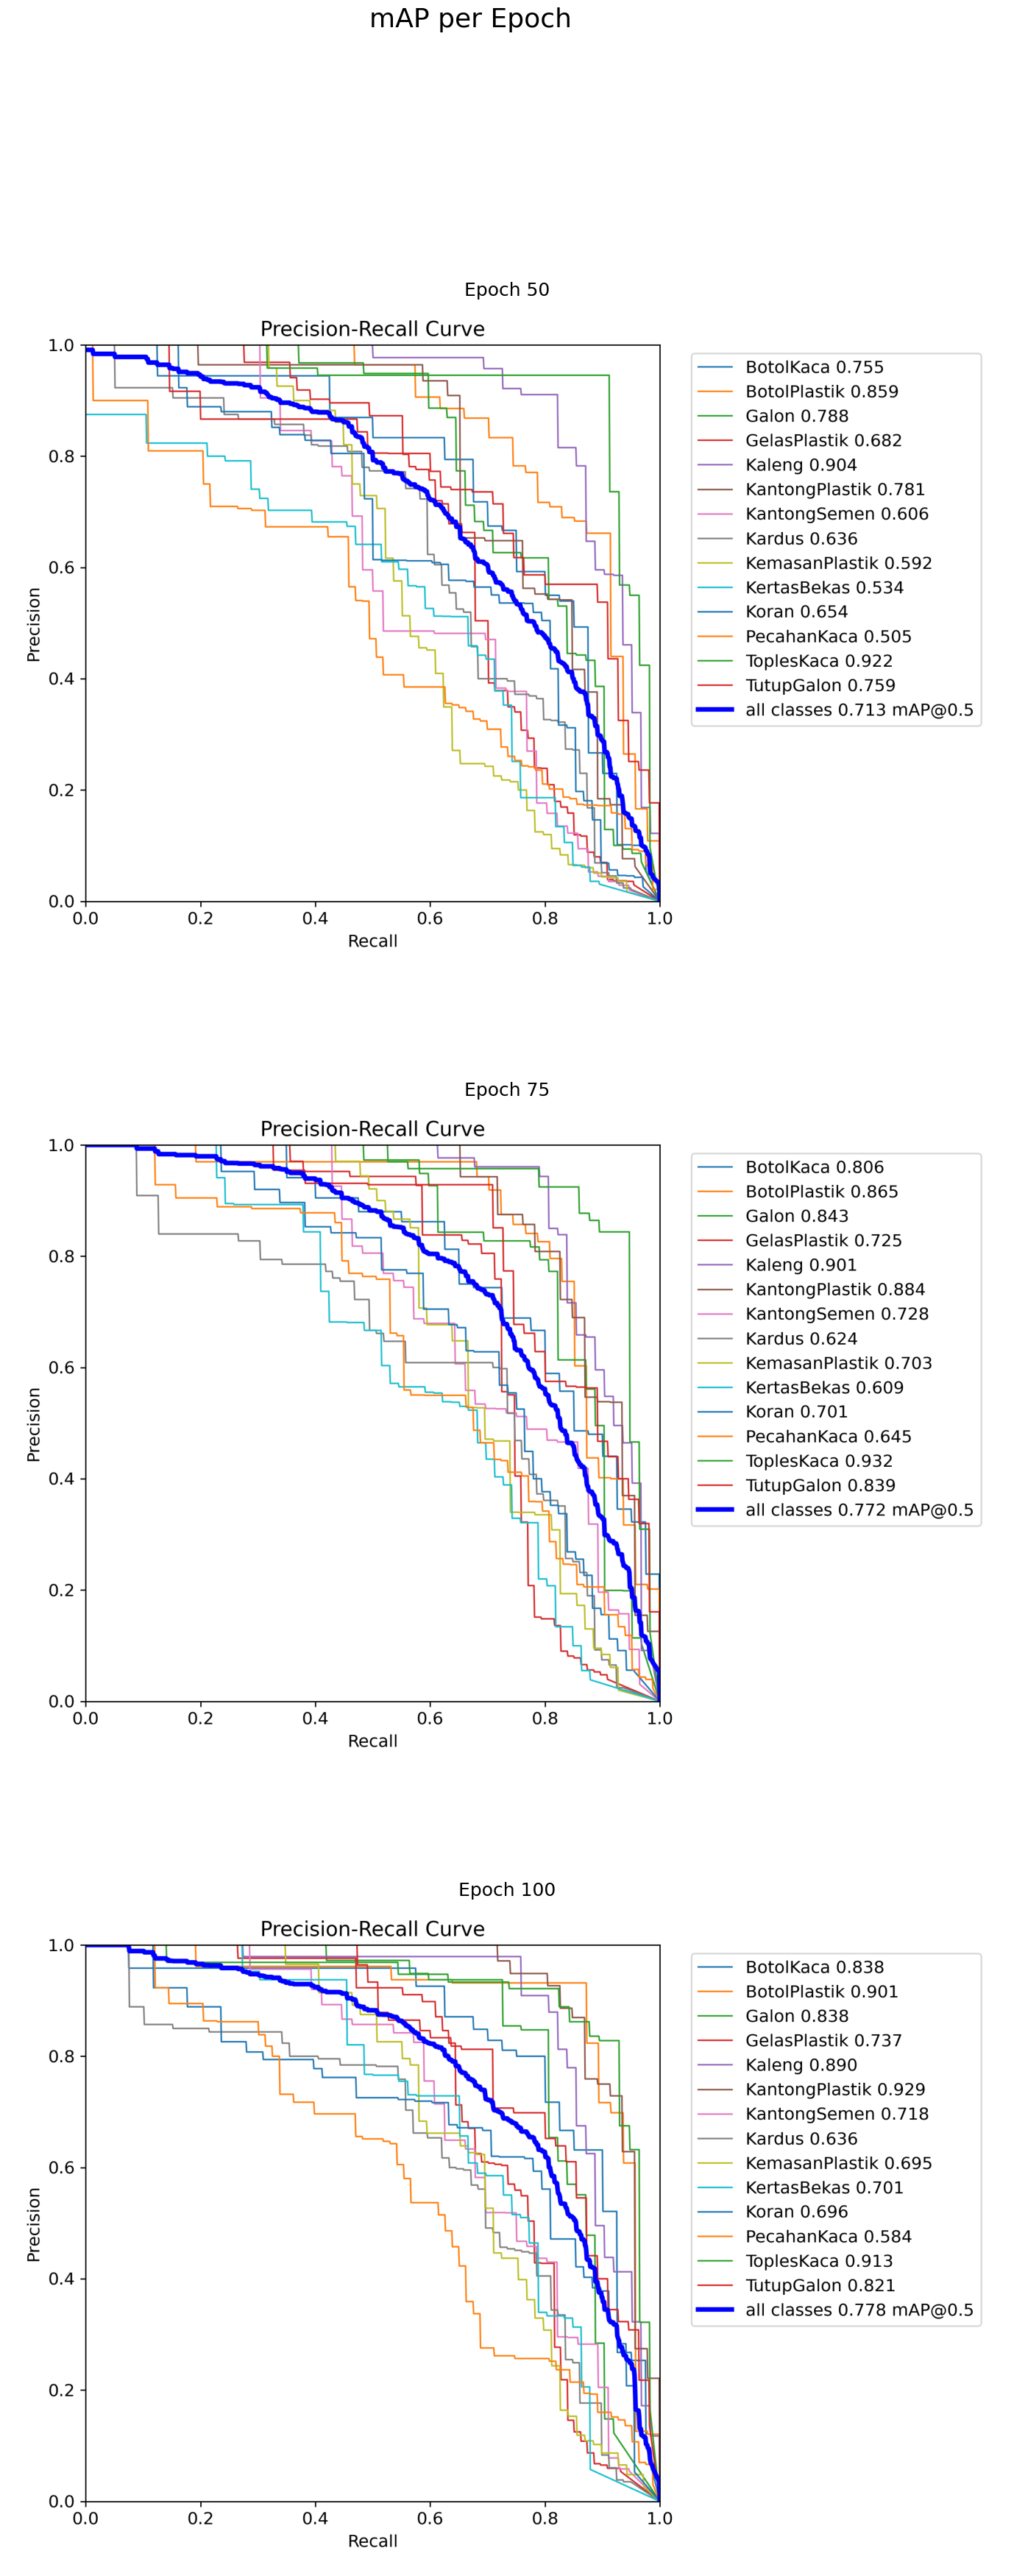

In [31]:
import cv2
import matplotlib.pyplot as plt

# Baca gambar-gambar (sesuaikan dengan path gambar Anda)
images = [cv2.imread(f) for f in ["//notebooks/runs/detect/yolov8s_e50_lr0.01/PR_curve.png", 
               "/notebooks/runs/detect/yolov8s_e75_lr0.01/PR_curve.png", 
               "/notebooks/runs/detect/yolov8s_e100_lr0.01/PR_curve.png"]]

titles = ["Epoch 50", "Epoch 75", "Epoch 100"]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(40, 40))

# Tampilkan setiap gambar pada axes yang sesuai
for i, img in enumerate(images):
    axes[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
    axes[i].set_title(titles[i], fontsize=18)

# Tambahkan judul utama
plt.suptitle("mAP per Epoch", fontsize=26)

plt.show()

**EPOCH 50 lr=0.01**
metrics/precision(B): 0.731818135622292
metrics/recall(B): 0.6272735587221876
metrics/mAP50(B): 0.7125088426106307
metrics/mAP50-95(B): 0.604510122971585
fitness: 0.6153099949354897

**EPOCH 75 lr=0.01**
metrics/precision(B): 0.7402685302658998
metrics/recall(B): 0.6874520849866478
metrics/mAP50(B): 0.7717506164269298
metrics/mAP50-95(B): 0.6535139561199309
fitness: 0.6653376221506307

**EPOCH 100 lr=0.01**
metrics/precision(B): 0.7737080360779374
metrics/recall(B): 0.6966391743031324
metrics/mAP50(B): 0.7786705548540968
metrics/mAP50-95(B): 0.6679428840856725
fitness: 0.6790156511625149

# TEST MODEL


0: 448x640 3 BotolPlastiks, 1 Galon, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


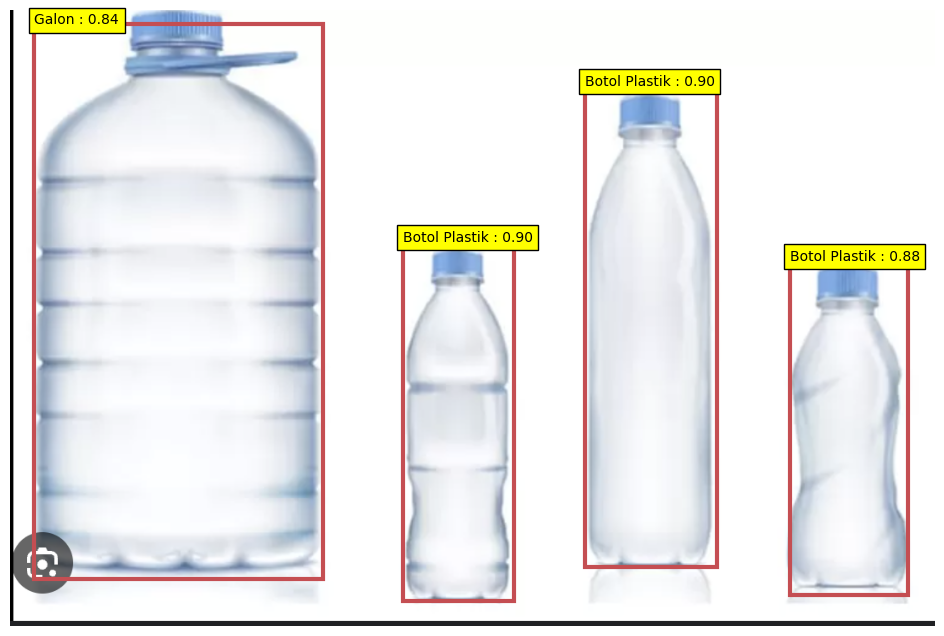

In [24]:
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load the custom-trained YOLOv8s model
model = YOLO('/notebooks/runs/detect/yolov8s_e100_lr0.01/weights/best.pt')  # Update with the path to your custom-trained model

# Define the classes (assuming your model was trained with the same classes)
class_names = [
    'Botol Kaca',
    'Botol Plastik',
    'Galon',
    'Gelas Plastik',
    'Kaleng',
    'Kantong Plastik',
    'Kantong Semen',
    'Kardus',
    'Kemasan Plastik',
    'Kertas Bekas',
    'Koran',
    'Pecahan Kaca',
    'Toples Kaca',
    'Tutup Galon'
]

# Function to load an image
def load_image(image_path):
    img = Image.open(image_path).convert("RGB")
    return img

# Load your image
image_path = '/notebooks/botol dan galon.png'  # Update with the path to your image
original_image = load_image(image_path)

# Perform detection
results = model(original_image)

# Visualize the image and the bounding boxes
def plot_predictions(image, results):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    ax = plt.gca()

    for result in results[0].boxes:  # Iterate through detected objects
        x1, y1, x2, y2 = result.xyxy[0].cpu().numpy()
        score = result.conf[0].cpu().numpy()
        label = class_names[int(result.cls[0].cpu().numpy())]
        if score > 0.5:  # Only plot if the score is above a threshold
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(x1, y1, f'{label} : {score:.2f}', bbox=dict(facecolor='yellow', alpha=1))

    plt.axis('off')
    plt.show()

plot_predictions(original_image, results)

# SAVE MODEL TO ONNX

In [ ]:
!pip install onnx tensorflow

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
from ultralytics import YOLO

# Load the YOLOv8 model
model = YOLO('/content/runs/detect/yolov8s_t1_e404/weights/best.pt')

# Export the model to TFLite format
model.export(format='onnx') # creates 'yolov8s_tf'

Ultralytics YOLOv8.2.16 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.30GHz)
Model summary (fused): 168 layers, 11131002 parameters, 0 gradients, 28.5 GFLOPs

PyTorch: starting from '/content/runs/detect/yolov8s_t1_e404/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 18, 8400) (21.5 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 1.4s, saved as '/content/runs/detect/yolov8s_t1_e404/weights/best.onnx' (42.7 MB)

Export complete (5.3s)
Results saved to /content/runs/detect/yolov8s_t1_e404/weights
Predict:         yolo predict task=detect model=/content/runs/detect/yolov8s_t1_e404/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/runs/detect/yolov8s_t1_e404/weights/best.onnx imgsz=640 data=/content/drive/MyDrive/ml/dataset/data.yaml  
Visualize:       https://netron.app


'/content/runs/detect/yolov8s_t1_e404/weights/best.onnx'

In [ ]:
onnx_model = YOLO('/content/runs/detect/yolov8s_t1_e404/weights/best.onnx')

# Run inference
results = onnx_model('/content/drive/MyDrive/ml/Screenshot 2024-05-15 185433.png')

Loading /content/runs/detect/yolov8s_t1_e404/weights/best.onnx for ONNX Runtime inference...

image 1/1 /content/drive/MyDrive/ml/Screenshot 2024-05-15 185433.png: 640x640 1 Galon, 732.3ms
Speed: 4.1ms preprocess, 732.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
